Creating a Holistic Model Score
To make a final decision, we can combine all our metrics into a single Holistic Score. This score will reward models for high accuracy and confidence while penalizing them for instability (high standard deviation).
Methodology:
Normalize: All metrics will be scaled from 0 to 1, so they can be compared fairly.
Invert: Standard Deviation will be inverted (1 - normalized_value) because lower is better.
Weight: We will assign weights to each metric based on importance.
Mean AP (60%): Accuracy is the most important factor.
Stability (1 - Std Dev) (30%): A model must be reliable. This is highly important.
Confidence (10%): Acts as a useful tie-breaker but is less critical than the other two.

Generating Graph 1: Model Performance Comparison (Mean AP)...


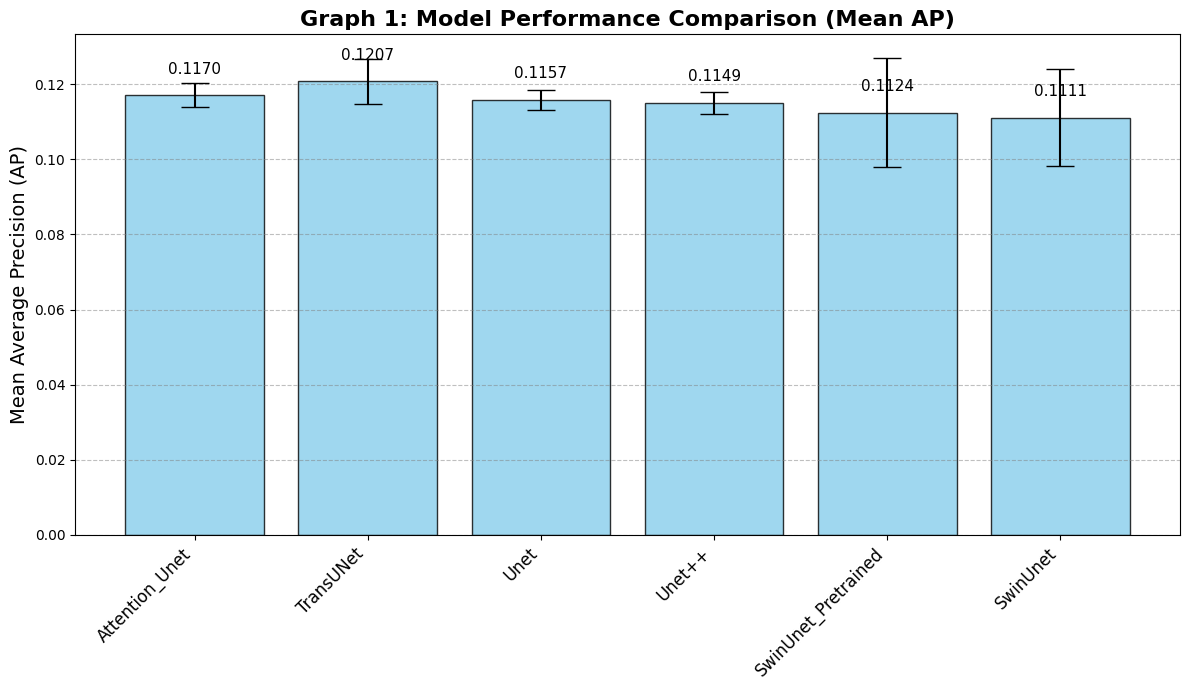

Generating Graph 2: Prediction Tendency (True vs. Predicted Pixels)...


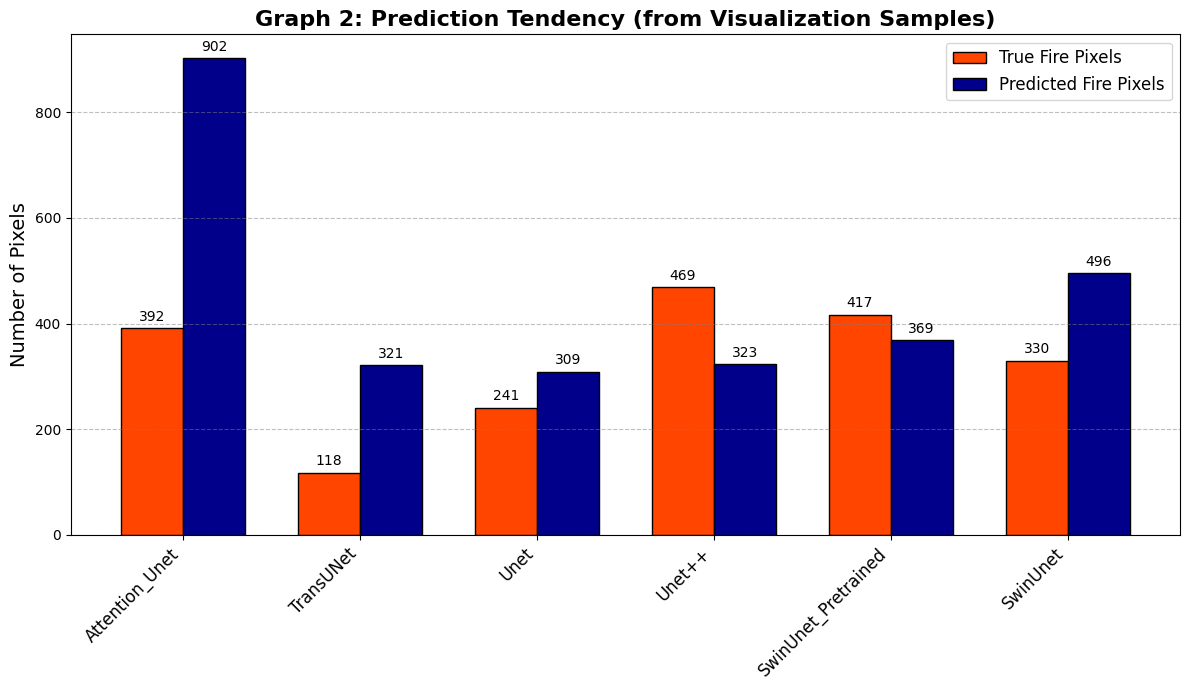

Generating Graph 3: Analysis of Secondary Metrics...


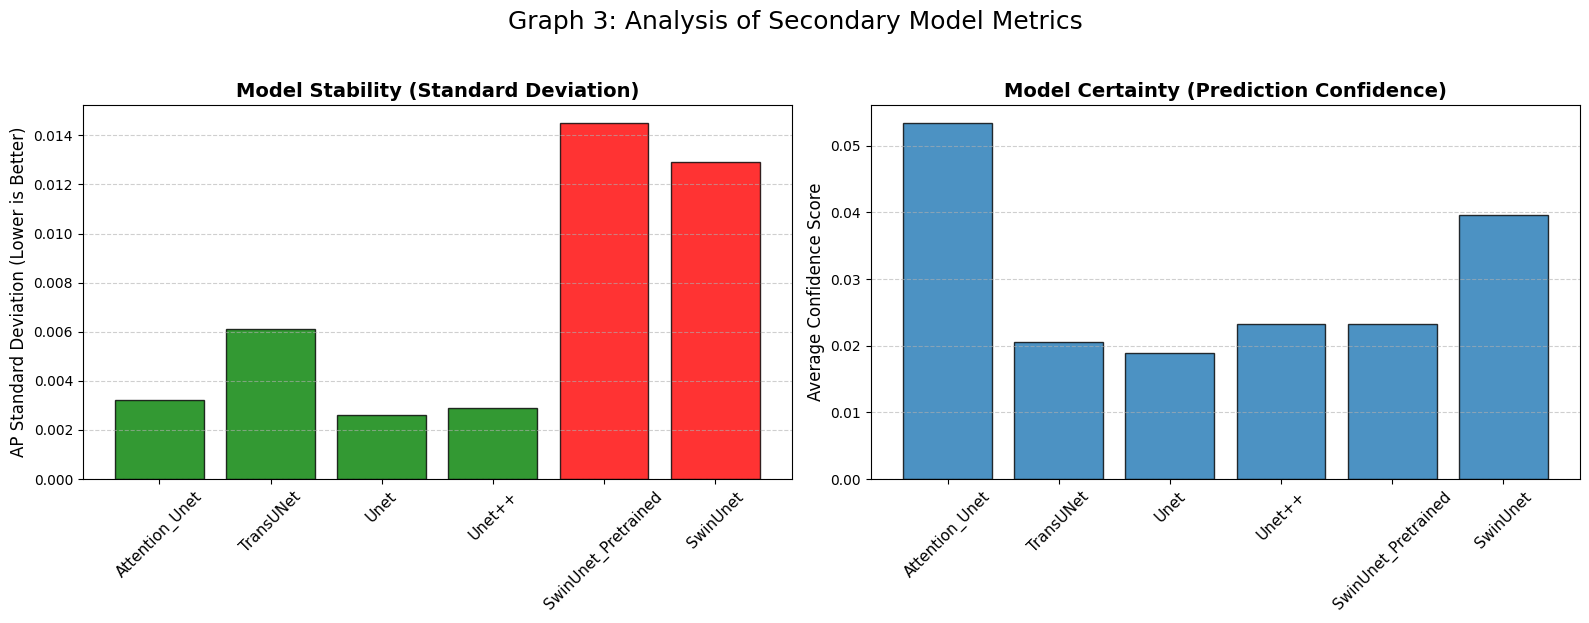

Generating Graph 5: Final Model Ranking (Holistic Score)...


C:\Users\Harshvardhan\AppData\Local\Temp\ipykernel_21588\437476108.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_models, rotation=45, ha='right', fontsize=12)


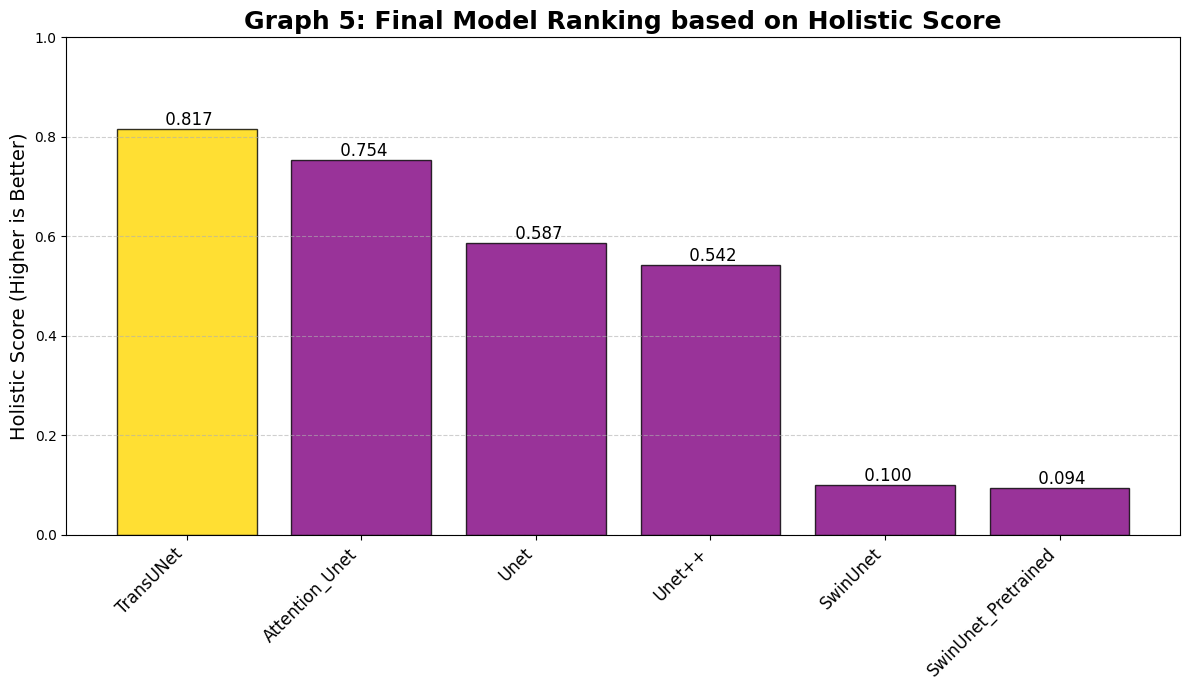


All visualizations have been generated.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg

# =============================================================================
# --- 1. CONSOLIDATED DATA FOR ALL MODELS ---
# =============================================================================
# All data is centralized here for easy access and modification.

MODELS = [
    'Attention_Unet', 'TransUNet', 'Unet', 'Unet++',
    'SwinUnet_Pretrained', 'SwinUnet'
]

DATA = {
    'mean_ap': [0.1170, 0.1207, 0.1157, 0.1149, 0.1124, 0.1111],
    'std_dev': [0.0032, 0.0061, 0.0026, 0.0029, 0.0145, 0.0129],
    'avg_confidence': [0.0534, 0.0206, 0.0189, 0.0232, 0.0233, 0.0396],
    'true_pixels': [392, 118, 241, 469, 417, 330],
    'predicted_pixels': [902, 321, 309, 323, 369, 496]
}


# =============================================================================
# --- 2. PLOTTING FUNCTION IMPLEMENTATIONS ---
# =============================================================================

def plot_quantitative_comparison(models, mean_aps, std_devs):
    """
    GRAPH 1: Generates a bar chart comparing model performance (Mean AP).
    The error bars represent the standard deviation, indicating stability.
    """
    print("Generating Graph 1: Model Performance Comparison (Mean AP)...")
    x_pos = np.arange(len(models))
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.bar(x_pos, mean_aps, yerr=std_devs, align='center', alpha=0.8,
           color='skyblue', capsize=10, edgecolor='black')
    ax.set_ylabel('Mean Average Precision (AP)', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=12)
    ax.set_title('Graph 1: Model Performance Comparison (Mean AP)', fontsize=16, fontweight='bold')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

    for i, v in enumerate(mean_aps):
        ax.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontsize=11)
        
    plt.tight_layout()
    plt.show()

def plot_pixel_tendency(models, true_pixels, predicted_pixels):
    """
    GRAPH 2: Generates a grouped bar chart to show if models are 
    conservative or aggressive in their predictions.
    """
    print("Generating Graph 2: Prediction Tendency (True vs. Predicted Pixels)...")
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, true_pixels, width, label='True Fire Pixels', color='orangered', edgecolor='black')
    rects2 = ax.bar(x + width/2, predicted_pixels, width, label='Predicted Fire Pixels', color='darkblue', edgecolor='black')

    ax.set_ylabel('Number of Pixels', fontsize=14)
    ax.set_title('Graph 2: Prediction Tendency (from Visualization Samples)', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right", fontsize=12)
    ax.legend(fontsize=12)
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    # Attach text labels above each bar
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

def plot_secondary_metrics(models, std_devs, avg_confidence):
    """
    GRAPH 3: Generates two subplots for Standard Deviation (stability) and 
    Average Prediction Confidence (certainty).
    """
    print("Generating Graph 3: Analysis of Secondary Metrics...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: AP Standard Deviation (Lower is Better)
    colors_std = ['red' if x > 0.01 else 'green' for x in std_devs]
    ax1.bar(models, std_devs, color=colors_std, edgecolor='black', alpha=0.8)
    ax1.set_title('Model Stability (Standard Deviation)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('AP Standard Deviation (Lower is Better)', fontsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=11)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Average Prediction Confidence (Higher is generally Better)
    ax2.bar(models, avg_confidence, color='C0', edgecolor='black', alpha=0.8)
    ax2.set_title('Model Certainty (Prediction Confidence)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Confidence Score', fontsize=12)
    ax2.tick_params(axis='x', rotation=45, labelsize=11)
    ax2.yaxis.grid(True, linestyle='--', alpha=0.6)
        
    fig.suptitle('Graph 3: Analysis of Secondary Model Metrics', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()

def display_model_predictions(models, image_folder='prediction_images'):
    """
    GRAPH 4: Loads and displays a grid of model prediction images for
    direct qualitative comparison.
    """
    print("Generating Graph 4: Side-by-Side Qualitative Comparison...")
    
    image_files = [f"{model}.png" for model in models]
    num_images = len(image_files)
    cols = 3
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for i, file_name in enumerate(image_files):
        ax = axes[i]
        model_name = models[i]
        file_path = os.path.join(image_folder, file_name)
        
        try:
            img = mpimg.imread(file_path)
            ax.imshow(img)
            ax.set_title(model_name, fontsize=16, fontweight='bold')
        except FileNotFoundError:
            ax.text(0.5, 0.5, f"Image Not Found:\n{file_path}", ha='center', va='center', fontsize=12, color='red')
            ax.set_title(f"{model_name} (Error)", fontsize=16)
        finally:
            ax.axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(pad=0.5)
    fig.suptitle('Graph 4: Side-by-Side Comparison of Model Predictions', fontsize=24, y=1.0)
    plt.show()

def plot_holistic_scores(models, data):
    """
    GRAPH 5: Calculates and plots a final holistic score to rank models
    based on a weighted combination of all metrics.
    """
    print("Generating Graph 5: Final Model Ranking (Holistic Score)...")
    
    # Normalize the data
    scaler = MinMaxScaler()
    norm_ap = scaler.fit_transform(np.array(data['mean_ap']).reshape(-1, 1)).flatten()
    norm_std = scaler.fit_transform(np.array(data['std_dev']).reshape(-1, 1)).flatten()
    norm_conf = scaler.fit_transform(np.array(data['avg_confidence']).reshape(-1, 1)).flatten()
    
    # Invert the standard deviation score (since lower is better)
    norm_stability = 1 - norm_std

    # Define weights (can be tuned based on priorities)
    weights = {'ap': 0.60, 'stability': 0.30, 'confidence': 0.10}

    # Calculate the final holistic score
    holistic_scores = (weights['ap'] * norm_ap +
                       weights['stability'] * norm_stability +
                       weights['confidence'] * norm_conf)

    # Sort models by score for plotting
    sorted_pairs = sorted(zip(models, holistic_scores), key=lambda item: item[1], reverse=True)
    sorted_models, sorted_scores = zip(*sorted_pairs)

    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.bar(sorted_models, sorted_scores, color='purple', edgecolor='black', alpha=0.8)

    ax.set_ylabel('Holistic Score (Higher is Better)', fontsize=14)
    ax.set_title('Graph 5: Final Model Ranking based on Holistic Score', fontsize=18, fontweight='bold')
    ax.set_xticklabels(sorted_models, rotation=45, ha='right', fontsize=12)
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    
    # Highlight the winner
    bars[0].set_color('gold')
    bars[0].set_edgecolor('black')

    for i, v in enumerate(sorted_scores):
        ax.text(i, v, f" {v:.3f}", ha='center', va='bottom', fontsize=12)
        
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()


# =============================================================================
# --- 3. MAIN EXECUTION BLOCK ---
# =============================================================================
if __name__ == "__main__":
    
    # --- Plot quantitative metrics ---
    plot_quantitative_comparison(MODELS, DATA['mean_ap'], DATA['std_dev'])
    plot_pixel_tendency(MODELS, DATA['true_pixels'], DATA['predicted_pixels'])
    plot_secondary_metrics(MODELS, DATA['std_dev'], DATA['avg_confidence'])
    
    # --- Plot qualitative image comparison ---
    # !! IMPORTANT !!
    # This function requires a folder named 'prediction_images' with your
    # named PNG files inside. If the folder/files do not exist, it will show an error.
    # Uncomment the line below when you are ready.
    # display_model_predictions(MODELS, image_folder='prediction_images')
    
    # --- Plot the final weighted score and ranking ---
    plot_holistic_scores(MODELS, DATA)

    print("\nAll visualizations have been generated.")

Attempting to display model prediction images...
Looking for images in: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures
Files to load: ['Attention_Unet.png', 'TransUNet.png', 'Unet.png', 'Unet++.png', 'SwinUnet_Pretrained.png', 'SwinUnet.png']
✓ Path exists
Files found in directory: ['Attention_Unet.png', 'SwinUnet.png', 'SwinUnet_Pretrained.png', 'TransUNet.png', 'Unet++.png', 'Unet.png']
Trying to load: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures\Attention_Unet.png
Trying to load: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures\TransUNet.png
Trying to load: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures\Unet.png
Trying to load: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures\Unet++.png
Trying to load: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures\SwinUnet_Pretrained.png
Trying to load: c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures

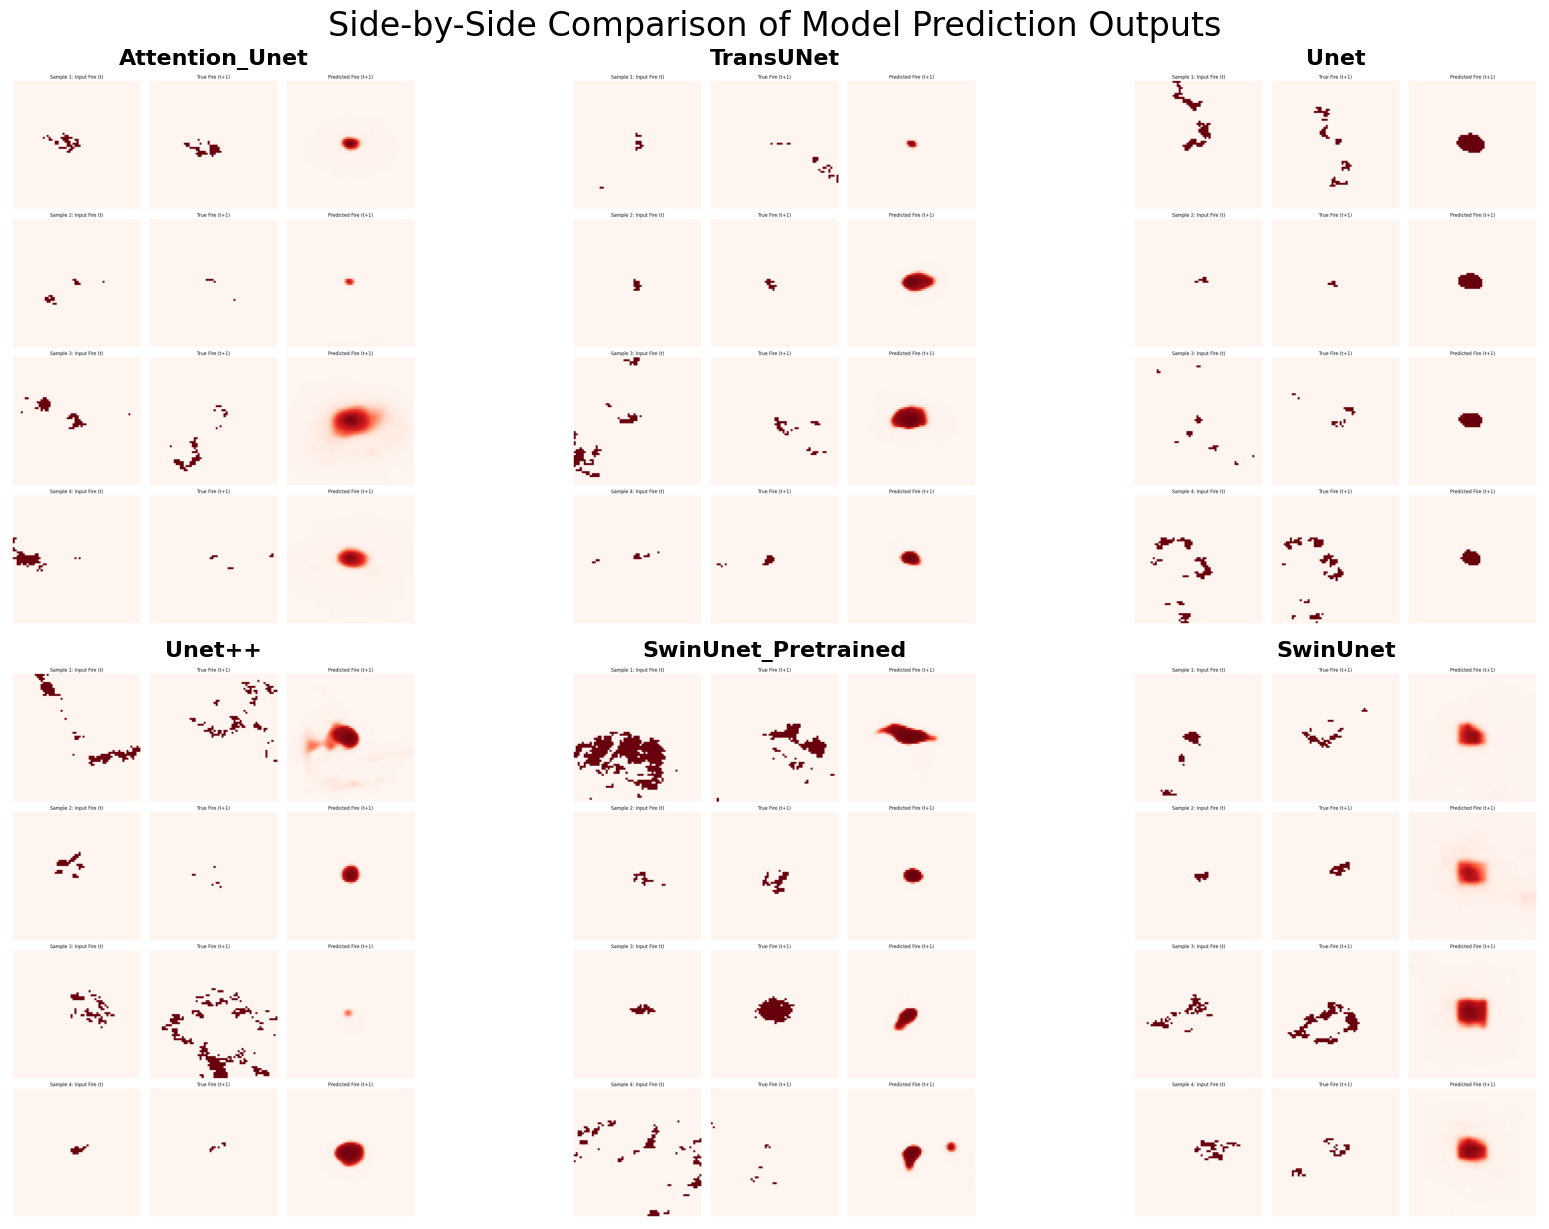

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os

# --- INSTRUCTIONS ---
# 1. Place your prediction images in a designated folder.
# 2. Update the `image_path` variable with the path to that folder.
# 3. Ensure the image file names match the `image_files` list exactly.

# --- Configuration ---
# Use absolute path to ensure it works
image_path = r'c:\Users\Harshvardhan\OneDrive\Desktop\wildfire_pred\reports\figures'

# Updated image files to match actual files in the directory
image_files = [
    'Attention_Unet.png',
    'TransUNet.png',  # Fixed: was 'TransUNet.png' 
    'Unet.png',
    'Unet++.png',
    'SwinUnet_Pretrained.png',
    'SwinUnet.png'
]

# --- Function to Display Images Side-by-Side ---
def display_model_predictions(image_files, image_path='.'):
    """
    Loads and displays a grid of model prediction images from a specified path.

    Args:
        image_files (list): A list of image file names.
        image_path (str): The path to the folder containing the images.
                          Defaults to the current directory.
    """
    # Define the grid layout
    num_images = len(image_files)
    cols = 3
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i, file_name in enumerate(image_files):
        try:
            # Construct the full path to the image
            full_path = os.path.join(image_path, file_name)
            print(f"Trying to load: {full_path}")  # Debug print
            img = mpimg.imread(full_path)

            ax = axes[i]
            ax.imshow(img)
            # Use the file name (without extension) as the title
            model_name = os.path.splitext(file_name)[0]
            ax.set_title(model_name, fontsize=16, fontweight='bold')
            ax.axis('off')  # Hide the axes
        except FileNotFoundError:
            print(f"Error: Image '{file_name}' not found in '{image_path}'. Please check the file name and path.")
            ax = axes[i]
            ax.text(0.5, 0.5, f"Image Not Found:\n{file_name}", ha='center', va='center', fontsize=12, color='red')
            ax.set_title("Error", fontsize=16)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading '{file_name}': {e}")
            ax = axes[i]
            ax.text(0.5, 0.5, f"Error Loading:\n{file_name}\n{str(e)}", ha='center', va='center', fontsize=10, color='red')
            ax.set_title("Error", fontsize=16)
            ax.axis('off')

    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Side-by-Side Comparison of Model Prediction Outputs', fontsize=24, y=1.02)
    plt.show()

# --- Run the display function ---
print("Attempting to display model prediction images...")
print(f"Looking for images in: {image_path}")
print(f"Files to load: {image_files}")

# Check if path exists
if os.path.exists(image_path):
    print("✓ Path exists")
    # List actual files in the directory
    actual_files = os.listdir(image_path)
    print(f"Files found in directory: {actual_files}")
else:
    print("✗ Path does not exist")

# Fixed: Uncommented the function call to actually display the images
display_model_predictions(image_files, image_path)